# Minimal dummy example with ictdeploy
## Creating a co-simulation graph
We consider the following two nodes graph as a minimal dummy example of two nodes exchanging a variable and randomly add or substract a given value from it:

<img src="./figures/model.png" alt="Model" style="width: 500px;"/>

The above graph can be created using ictdeploy as follow:

In [1]:
import os
from ictdeploy import Simulator as Sim

In [2]:
#create empty simulator
sim = Sim()

In [3]:
#create Meta-model
sim.edit.add_meta(
        name="BaseMeta",
        set_attrs=[""],
        get_attrs=["senTemOut.T"]
    )

'BaseMeta'

In [4]:
#create Meta-model
sim.edit.add_meta(
        name="Base2Meta",
        set_attrs=["Tsupply"],
        get_attrs=["Tindoor"]
    )

'Base2Meta'

In [5]:
#create Model
sim.edit.add_model(
        name="BaseModel",
        meta="BaseMeta",
        image="",
        wrapper=os.path.join("wrappers", "base_wrap.py"),
        command=None,
        files=[os.path.join("files_to_add", "IBPSA_Fluid_FixedResistances_Examples_PlugFlowPipe.fmu")]
    )

'BaseModel'

In [6]:
#create Model
sim.edit.add_model(
        name="Base2Model",
        meta="Base2Meta",
        image="integrcity/ict-simple",
        wrapper=os.path.join("wrappers", "building_wrap.py"),
        command=None,
        files=[os.path.join("files_to_add", "empty_file.txt")]
    )

'Base2Model'

Now that our `Meta-models` and `Models` have been created, we can populate our `Simulator` with `Nodes` as follow:

In [7]:
#add node
sim.edit.add_node(
        name="Base0",
        model="BaseModel",
        init_values={},
        is_first=True,
        is_local=True
    )

'Base0'

In [8]:
#add node
sim.edit.add_node(
        name="Base1",
        model="Base2Model",
        init_values={}        
    )

'Base1'

And add `Links` between the created `Nodes` as follow:

In [9]:
sim.edit.add_link(get_node="Base0", get_attr="senTemOut.T", set_node="Base1", set_attr="Tsupply")
sim.edit.add_link(get_node="Base1", get_attr="Tindoor", set_node="Base0", set_attr="")

## Data structure
The created co-simulation graph can be described by the following tables, gathering information about `Nodes` and `Links`.

In [10]:
sim.edit.nodes

,meta,model,to_set,to_get,image,wrapper,files,command,init_values,is_first,is_local
Base0,BaseMeta,BaseModel,[],[senTemOut.T],,wrappers\base_wrap.py,[files_to_add\IBPSA_Fluid_FixedResistances_Exa...,None,{},True,True
Base1,Base2Meta,Base2Model,[Tsupply],[Tindoor],integrcity/ict-simple,wrappers\building_wrap.py,[files_to_add\empty_file.txt],None,{},False,False


In [11]:
sim.edit.links

,get_attr,get_node,set_attr,set_node
0,senTemOut.T,Base0,Tsupply,Base1
1,Tindoor,Base1,,Base0


## Simulation parameters
Based on the created co-simulation graph, we can now create `Groups`, `Sequence` and `Steps` for the simulation as follow:

In [12]:
grp0 = sim.create_group("Base0")
grp1 = sim.create_group("Base1")

In [13]:
sim.create_sequence(grp0, grp1)
sim.create_steps([1] * 10800)

## Running simulation
Everything is ready, we just have to run the simulation using `Simulator.run_simulation()`

In [14]:
logs = sim.run_simulation(server="server.py")

In [15]:
print(logs["nodes"]["Base0"].replace("172.17.01", "localhost"))

python base_wrap.py localhost Base0 init_values.json --i= --o=senTemOut.T --first


In [16]:
for l in sim.get_logs(logs["orc"]):
    if "INFO" in l:
        print(l)

INFO - 2018-06-28 12:49:05,994 - Connected to 172.17.01/obnl_vhost
INFO - 2018-06-28 12:49:06,010 - scheduler initialised.
INFO - 2018-06-28 12:49:06,833 - Simulator Base1 is connected.
INFO - 2018-06-28 12:49:23,647 - Simulator Base0 is connected.
INFO - 2018-06-28 12:49:23,647 - Start simulation.
INFO - 2018-06-28 12:53:51,065 - Simulation finished. Execution time: 267.4181957244873 seconds


## Retrieving results
Now that the simulation is finished, we can connect to the database of results and list all the available stored values as follow:

In [17]:
sim.results.connect_to_results_db(host="localhost")
sim.results.list_of_available_results

,IN/OUT,Node,Attribute
0,OUT,Base1,Tindoor
1,IN,Base1,Tsupply
2,IN,Base0,
3,OUT,Base0,senTemOut.T


Based on the preceding available stored values, we can choose wich results to get using a pattern matching the name of the selected values.

In [18]:
results = sim.results.get_results_by_pattern("OUT*")
results.keys()

dict_keys(['OUT||Base0||senTemOut.T', 'OUT||Base1||Tindoor'])

And finnaly, we plot the selected results using `matplotlib`.

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

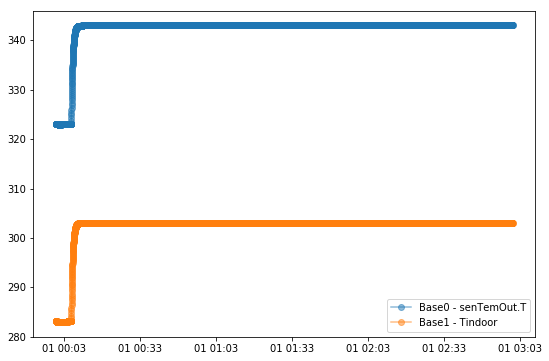

In [20]:
plt.figure(figsize=(9, 6))
plt.plot(results['OUT||Base0||senTemOut.T'], "-o", label="Base0 - senTemOut.T", alpha=0.5)
plt.plot(results['OUT||Base1||Tindoor'], "-o", label="Base1 - Tindoor", alpha=0.5)
plt.legend()